# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [88]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [89]:
import configparser

config = configparser.ConfigParser()
config.read("env_config_test.ini")

environments = {}
for section in config.sections():
    M = config.getint(section, "number_of_agents")
    N = config.getint(section, "grid_size")
    goals = eval(config.get(section, "goals"))
    mission_statement = eval(config.get(section, "mission_statement"))
    # num_trials = config.getint(section, "number_of_trials")
    environments[section] = {
        "N": N,
        "M": M,
        "goals": goals,
        "mission_statement": mission_statement,
    }

In [85]:
from models import local_llm as llm
from planner import SuperPlanner as Planner

In [86]:
plans = []
selected_env = environments["env.3"]
env = multigrid.envs.EmptyEnvV2(
    size=selected_env["N"],  # Specify the size of the grid, N
    agents=selected_env["M"],  # Specify number of agents, M
    goals=selected_env["goals"],  # Specify target positions for agents
    mission_space=selected_env["mission_statement"],
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

agents = AgentCollection(num=selected_env["M"])

planner = Planner(
    llm=llm, grid_size=selected_env["N"], observations=observations, infos=infos
)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
text_plan, plan = planner.initial_plan()
for agent, actions in plan.items():
    for action in actions:
        agents.tell({agent: action.serialize()})
plans.append((text_plan, plan))

We are on a 100×100 grid with 5 agents starting at (1,1). There are exactly 2 targets, and they are always located together — either both in Region A: (10,10) to (30,30) with 70% probability, or both in Region B: (70,70) to (90,90) with 30% probability.  

Critical constraints from intel:  
- The central square from (35,35) to (65,65) is confirmed empty.  
- No targets within Manhattan distance 7 of (20,80) → this excludes a diamond-shaped area around that point, but since Region B is far away (70,70–90,90), this does not intersect it.  
- The strip from (45,10) to (55,25) is guaranteed target-free.  

This means we must **avoid wasting any agent’s time** on the empty central zone, the forbidden strip, or near (20,80). Since targets are always together, finding one target implies the other is nearby — so we can treat each region as a single unit.

Our goal: Maximize reward by ensuring **both targets are found**, because missing even one gives us **zero bonus B**, which is enormous (~10

KeyboardInterrupt: 

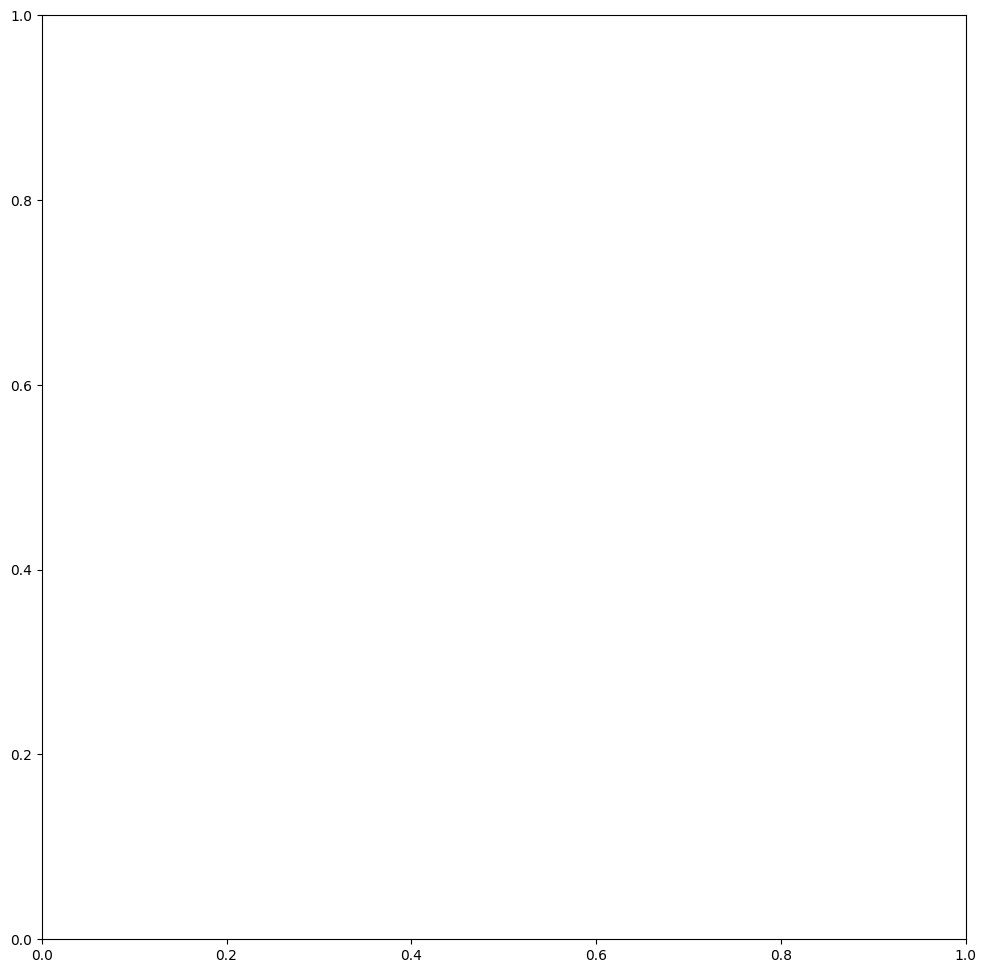

In [87]:
steps = 0
while not env.unwrapped.is_done():
    steps += 1
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)

    if steps % 1 == 0:
        # Render the environment
        clear_output(wait=True)
        img = env.render()
        plt.figure(figsize=(12, 12))
        plt.imshow(img[::-1, :])
        plt.show()

    if env.unwrapped.is_done():
        break

    text_plan, plan = planner.replan(
        agents, observations, rewards, terminations, truncations, infos
    )
    plans.append((text_plan, plan))
    for agent, actions in plan.items():
        agents.tell({agent: "stop()"})
        for action in actions:
            agents.tell({agent: action.serialize()})


print(infos["total_reward"])
env.close()